In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# This model calculates the $ value of SKR as the price of ETH crashes, causing liquidation of CDPs.
# Throughout, 'SKR value' refers to the $ value you get by claiming ETH from the system,
# taking into account liquidation penalties

liquidation_ratio = 1.5

# I have set an absurdly high liquidation penalty so that the effect is more visible on the graphs, feel free to adjust
liquidation_penalty = 0.20
#liquidation_penalty = 0.05

# In this model, we assume that the number of ETH in the SKR pool stays constant throughout the process

eth_in_pool = 1

# These are the initial values, which will change in the recapitalisation process

initial_SKR = 1
initial_SKR_in_CDP = 1
initial_outstanding_Sai = 100

# new parameter proposed for limited liquidation, see explanation below
reserve_ratio  = 2

In [3]:
def get_SKR_value(eth_price, use_alternative_liquidation=False):
    # calculates SKR price after Sai recapitalisation via SKR minting has occured
    # n.b. that this model assumes that the ETH price has moved instantaneously to its current level
    # so we are recapitalising the system all at once.
    # in particular, this means that the collateral SKR and the minted SKR are
    # sold off 'together', i.e. the collateral SKR is sold off at the diluted, post-minting price
    # I think this is a reasonable assumption since no one would buy SKR at its previous value
    # when it is clear that the system is shortly going to have to mint SKR to recapitalise
    pool_value = eth_in_pool * eth_price
    collateral_value = (initial_SKR_in_CDP/initial_SKR) * pool_value
    if collateral_value >= initial_outstanding_Sai:
        # if we are above the liquidation ratio, no liquidation so no liquidation penalty is charged
        if collateral_value/initial_outstanding_Sai >= liquidation_ratio:
            # no liquidation, SKR supply unchanged
            return pool_value / initial_SKR
        else:
            if use_alternative_liquidation:
                # calculates liquidation penalty using alternative, partial liquidation
                liquidated_SKR = (initial_SKR * reserve_ratio*initial_outstanding_Sai - initial_SKR_in_CDP * pool_value)/(pool_value *(reserve_ratio - 1))
            else:
                liquidated_SKR = (initial_SKR * initial_outstanding_Sai)/pool_value
            max_penalty = liquidation_penalty*liquidated_SKR
            after_liquidation_SKR_in_CDP = initial_SKR_in_CDP - liquidated_SKR
            penalty = min(after_liquidation_SKR_in_CDP, max_penalty)
            return pool_value / (initial_SKR - penalty)
    elif pool_value >= initial_outstanding_Sai:
        # minting required to bail out Sai, SKR is diluted
        return (pool_value - initial_outstanding_Sai)/(initial_SKR - initial_SKR_in_CDP)
    else:
        # not enough in the MKR pool to bail out Sai
        return 0
    
get_SKR_value_vect = np.vectorize(get_SKR_value)

def plot_SKR_value(show_alternative_liquidation=False):
    # optionally displays alternative, limited liquidation scenario with dotted line
    
    max_point = 300
    
    # price at which Sai meets reserve requirements (limited liquidation)
    #reserve_point = (reserve_ratio * initial_outstanding_Sai * initial_SKR) / (initial_SKR_in_CDP * eth_in_pool)
    # price at which CDPs should be liquidated to recapitalise
    liquidation_point = (liquidation_ratio * initial_outstanding_Sai * initial_SKR) / (initial_SKR_in_CDP * eth_in_pool)
    # price at which SKR starts to be minted
    minting_point = initial_outstanding_Sai * initial_SKR / (eth_in_pool * initial_SKR_in_CDP)
    # price at which we can no longer recapitalise
    fail_point = initial_outstanding_Sai / eth_in_pool
    
    eth_price = np.arange(0, max_point, 0.5)
    
    fig = plt.figure(figsize=(10, 5), dpi=100)
    
    plt.plot(eth_price, get_SKR_value_vect(eth_price, use_alternative_liquidation=False), 'b', label="original")
    if show_alternative_liquidation:
        plt.plot(eth_price, get_SKR_value_vect(eth_price, use_alternative_liquidation=True), 'b:', label="alternative")
    plt.legend(loc=4)

    # plot the critical points
    #plt.axvline(x=reserve_point, linestyle='--', color='green')
    #plt.text(reserve_point+ max_point/100, 0.9*max_point*eth_in_pool/initial_SKR, 'Reserve Point', color='green')
    plt.axvline(x=liquidation_point, linestyle='--', color='purple')
    plt.text(liquidation_point+ max_point/100, 0.85*max_point*eth_in_pool/initial_SKR, 'Liquidation Point', color='purple')
    plt.axvline(x=minting_point, linestyle='-.', color='orange')
    plt.text(minting_point+ max_point/100, 0.8*max_point*eth_in_pool/initial_SKR, 'Minting Point', color='orange')
    plt.axvline(x=fail_point, linestyle=':', color='red')
    plt.text(fail_point + max_point/100, 0.75*max_point*eth_in_pool/initial_SKR, 'Fail Point', color='red')

    plt.xlabel('$ price of ETH')
    plt.ylabel('$ value of SKR (after liquidation, if any)')
    #plt.title('Optional Title')

    #plt.show()
    return fig

$l$: liquidation ratio

$l_P$: liquidation penalty

$\mathcal{O}_S$: number of outstanding Sai

$n_S$: number of outstanding SKR

$n_c$: number of SKR held in CDPs

$n_\epsilon$: number of ETH held in SKR pool

$p_\epsilon$: current \$ market price of ETH

$V_S = n_\epsilon p_\epsilon$: current \$ value of SKR pool

$p_S = \frac{V_S}{n_S}$: current \$ value of 1 SKR

$V_c = \frac{n_c}{n_S} V_S$: current \$ value of CDP pool

$\mathcal{C} = \frac{V_c}{\mathcal{O}_s}$: current collateral ratio

# The Recapitalisation of Sai

Throughout, we assume that the sole value of SKR is derived from its claim on assets in the SKR pool, ignoring any additional (and subjective) value deriving from a claim on future income from either stability fees or liquidation penalties (more on that later). We do take into account the effect of liquidation penalties on SKR holders' claims on ETH in the pool. We assume that there is a single CDP in the system, or (equivalently a number of CDPs, all at the same collateral ratio).

### How Sai works

If $\mathcal{C} < l$, the system liquidates the collateral SKR in the CDPs, selling it for Sai, until all of the outstanding Sai has been removed from the system. The system needs to buy back $\mathcal{O}_S$ Sai, while selling off $\Delta n_c$ collateral SKR, and if necessary, minting $\Delta n_S$ new SKR. So after the operation, the new quantities will be:

$\mathcal{O}^\prime_S = 0$

$n^\prime_S = n_S + \Delta n_S$

$n^\prime_c = n_c - \Delta n_c$

Meanwhile, the new \$ value of SKR after the operation (and thus the sale price of SKR during the operation) will be $p^\prime_S = \frac{V_S}{n\prime_S}$. The system sells off $\Delta n_c$ SKR taken from CDPs and $\Delta n_S$ SKR that was newly minted (if there is no minting, then $\Delta n_S = 0$), thus the \$ value of the proceeds[1] from the sale is $(\Delta n_c + \Delta n_S)p^\prime_S$. This must balance with the purchased Sai, thus $\mathcal{O}_S = (\Delta n_c + \Delta n_S)p^\prime_S$. This leaves us with:

$\mathcal{O}_S = \frac{(\Delta n_c + \Delta n_S)V_S}{n_S + \Delta n_S}$

Now if the system isn't undercollateralised, i.e. if $V_c \ge \mathcal{O}_S$, then we needn't mint any SKR, so $\Delta n_S = 0$, and we can solve for $\Delta n_c$:

$\Delta n_c = \frac{n_S \mathcal{O}_S}{V_S}$

We can check that $\mathcal{O}_S \leq V_c $ implies that $\Delta n_c \leq n_c$, i.e. that we aren't reclaiming more SKR from CDPs than there is available. We also apply a liquidation penalty by burning up to $l_P \Delta n_c$ of the SKR remaining in the CDP. This reduces the SKR supply to $n_S - \min(l_P \Delta n_c, n_c - \Delta n_c)$, so the new price of SKR will be:

$p^\prime_S = \frac{V_S}{n_S - \min\left(l_P \Delta n_c, n_c - \Delta n_c\right)}$

On the other hand, if the system _is_ undercollateralised, i.e. if $V_c < \mathcal{O}_S$ then SKR must be minted to effectively make the non-CDP SKR holders bail out Sai. The corresponding ETH price when $V_c = \mathcal{O}_S$ is called the "**minting point**". All of the CDP collateral must then be liquidated, so $\Delta n_c = n_c$, and we can solve for $\Delta n_S$:

$\Delta n_S = \frac{\mathcal{O}_S - V_c}{n_S(V_S - \mathcal{O}_S)}$

After the operation, the \$ value of SKR was diluted to: $p^\prime_S = \frac{V_S - \mathcal{O}_S}{n_S - n_c}$. 

We _must_ have $V_S > \mathcal{O}_S$, otherwise there simply isn't enough value in the SKR pool to make Sai whole. The corresponding ETH price when $V_S = \mathcal{O}_S$ is called the "**fail point**", because then it is impossible for the system to recapitalise itself (without external intervention). 


So far, we have not taken into account any value added to SKR due to its claim on future stability fees, or future liquidation fees, etc. As it turns out, near the "fail point" this additional, subjective value quickly overtakes the value given to SKR by the ETH in the pool. Therefore, to assess the viability of a Sai bailout near the "fail point", we will need to (subjectively) model this component of SKR value.


### Alternative proposal: partial liquidation

Here is a proposal that would result in much less liquidation, while still keeping the system sufficiently collateralised. We introduce an additional parameter, which represents an "extra-safe" collateral ratio that is well above the liquidation ratio (e.g. if $l = 1.5$, we could have $r = 2$):

$r$: reserve ratio

If $\mathcal{C} < l$, the system begins to liquidate CDPs, selling the collateral SKR for Sai, but instead of repurchasing all of the outstanding Sai, it aims to remove just enough to reach a collateral ratio of $\mathcal{C}^\prime = r$. (When the system is undercollateralised, all of the collateral will need to be sold off, so we will have the same behaviour as before.)

The system can buy back $\Delta \mathcal{O}_S$ Sai, while selling off $\Delta n_c$ collateral SKR, and if necessary, minting $\Delta n_S$ new SKR. So after the operation, the new quantities will be:

$\mathcal{O}^\prime_S = \mathcal{O}_s - \Delta \mathcal{O}_S$

$n^\prime_S = n_S + \Delta n_S$

$n^\prime_c = n_c - \Delta n_c$

$\mathcal{C}^\prime = \frac{V_c}{\mathcal{O}^\prime_s}$

The contents of the SKR pool are assumed to be unchanged, so in order to reach the desired collateral ratio $\mathcal{C}^\prime = r$, we need to have:

$r \mathcal{O}^\prime_S = \frac{n^\prime_c}{n^\prime_S} V_S$

$r(\mathcal{O}_S - \Delta \mathcal{O}_S) = \frac{n_c - \Delta n_c}{n_S + \Delta n_S}V_S$

Meanwhile, the new \$ value of SKR after the operation (and thus the sale price of SKR during the operation) will be $p^\prime_S = \frac{V_S}{n\prime_S}$. The system sells off $\Delta n_c$ SKR taken from CDPs and $\Delta n_S$ SKR that was newly minted (if there is no minting, then $\Delta n_S = 0$), thus the \$ value of the proceeds[1] from the sale is $(\Delta n_c + \Delta n_S)p^\prime_S$. The Sai that is purchased is removed from the system, thus $\Delta \mathcal{O}_S = (\Delta n_c + \Delta n_S)p^\prime_S$.  Finally, we have:

$r\left(\mathcal{O}_S - \frac{V_S(\Delta n_c + \Delta n_S)}{n_S + \Delta n_S}\right) = \frac{n_c - \Delta n_c}{n_S + \Delta n_S}V_S$

Now if the system isn't undercollateralised, i.e. if $V_c \ge \mathcal{O}_S$, then we needn't mint any SKR, so $\Delta n_S = 0$, and we can solve for $\Delta n_c$:

$\Delta n_c = \frac{n_S r \mathcal{O}_S - n_cV_S}{V_s(r - 1)}$

Observe that in the limit $r \to \infty$, we recover the formula from before. Again, we can check that $\mathcal{O}_S \leq V_c $ implies that $\Delta n_c \leq n_c$, i.e. that we aren't reclaiming more SKR from CDPs than there is available. Similarly to before, we apply a liquidation penalty to the collateral that was liquidated.

As compared to the original procedure, we have liquidated substantially less collateral, while still keeping Sai well capitalised. For example, if $l = 1.5$ and $r=2$, up to $50\%$ less collateral needs to be liquidated. Interestingly, this also smoothes out the SKR value a bit (see graphs below), since limited liquidation brings in less fees than the original model when collateral price is close to the "liquidation point", but more fees than the original model when nearing the "minting point".

On the other hand, if the system _is_ undercollateralised, we must sell off all of the collateral, so we get the same behaviour as above.

[1]:
Note that we have taken into account here that minting new SKR will also reduce the sale value of the SKR reclaimed from CDPs, i.e. that both the minted SKR and the collateral SKR is sold off at the diluted, post-minting price. This is a reasonable assumption since any market participant should be able to predict whether or not minting is occurring and in what quantity by the above calculations and by knowing the price of ETH, and will thus adjust (downward) their subjective valuation of SKR.

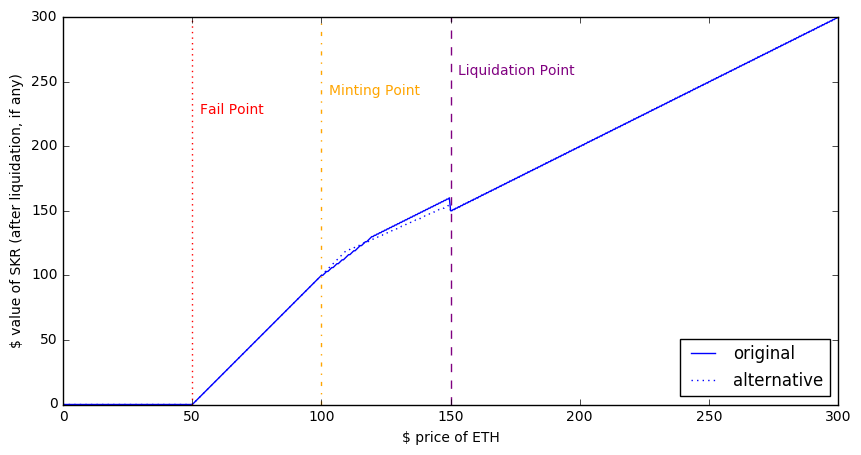

In [4]:
# if half of SKR is held in CDPs:

eth_in_pool = 2
initial_SKR = 2
initial_SKR_in_CDP = 1

plot_SKR_value(show_alternative_liquidation=True)

The slope between the "Minting Point" and the "Fail Point" will be called the "Minting Cliff". The less non-CDP SKR there is, the steeper the Minting Cliff. Observe also the interesting effect of alternative liquidation.

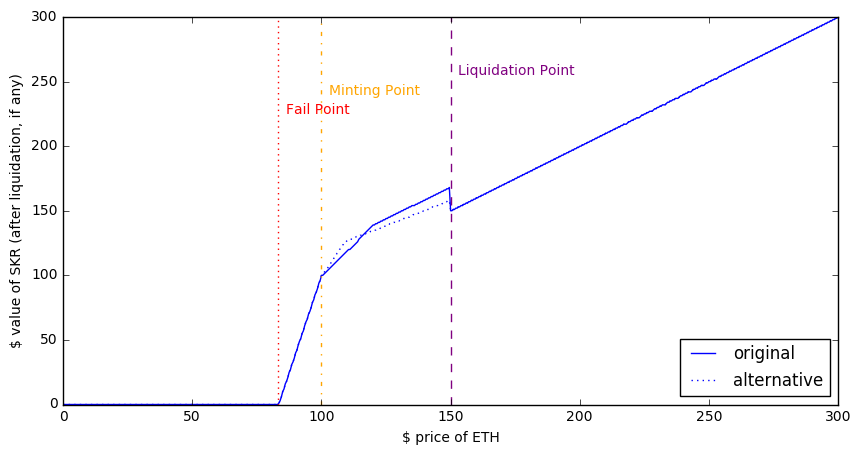

In [5]:
# if most (83%) of SKR is held in CDPs:

eth_in_pool = 1.2
initial_SKR = 1.2
initial_SKR_in_CDP = 1

plot_SKR_value(show_alternative_liquidation=True)

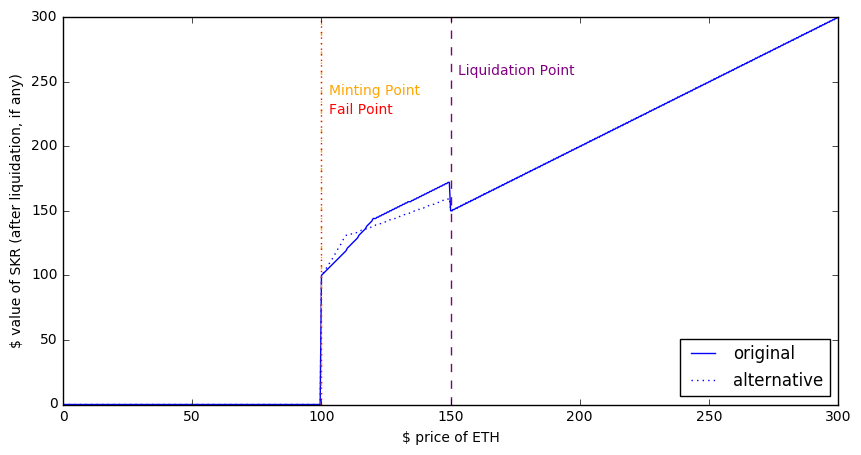

In [6]:
# if all SKR is held in CDPs:

eth_in_pool = 1
initial_SKR = 1
initial_SKR_in_CDP = 1

plot_SKR_value(show_alternative_liquidation=True)

In [7]:
plt.close("all")

# Modelling Subjective SKR Value

Stayed tuned for more...